# MATH60629
# Semaine \#2 - Fondamentaux de l'apprentissage automatique - Exos

Ces exercices portent sur trois aspects importants de l'apprentissage automatique (ML) : 
1. la capacité des modèles
2. le biais et la variance d'un estimateur (modèle), ainsi que
3. une courte introduction à la validation. 

Le but de ce notebook est de développer votre intuition à travers une série d'exercices.

In [1]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]
lasso = linear_model.Lasso()
y_pred = cross_val_predict(lasso, X, y, cv=3)

In [3]:
print(y_pred.shape)

(150,)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Pour colab.
#!rm -rf 80-629
#!git clone https://github.com/lcharlin/80-629/
#import sys
#sys.path += ['80-629/week2-Fundamentals/']

# Nous utiliserons plusieurs fonctions du fichier utilities.py pour créer des figures
from utilities import scatter_plot, plot_polynomial_curves, \
                      plot_optimal_curve, train_poly_and_see, MSE
%matplotlib inline

## 1.1 Capacité d'un modèle

Intuitivement, la capacité d'un modèle peut être définie comme le nombre de fonctions que ce modèle peut représenter (c.-à-d. obtenir une erreur d'entraînement de 0). Par rapport à un modèle de haute capacité, un modèle de basse capacité peut représenter moins de fonctions.

Les modèles à plus haute capacité sont en général plus sujets au surentraînement (**overfitting**). Un modèle est en surentraînement s'il y a une grande différence entre l'erreur d'entraînement et l'erreur de test. En d'autres mots, c'est quand le modèle mémorise des propriétés de l'ensemble d'entraînement qui ne sont pas utiles pour généraliser (bien prédire sur l'ensemble de test). 

Intuitivement, si deux modèles obtiennent des résultats similaires en entraînement, celui avec la plus petite capacité généralisera le mieux. Nous préférons donc une explication simple versus une explication plus compliquée (c'est une bonne illustration du [Rasoir d'Ockham](https://fr.wikipedia.org/wiki/Rasoir_d%27Ockham).

### 1.1.1 Génération de données

Commençons par simuler des données! Dans cette section, chaque observation $y$ est générée par le modèle suivant: 

$$ y = x \cos(x / \gamma) + \epsilon$$

où $y \in \mathbb{R}$ est la cible ou sortie (la variable dépendante qui sera à prédire), $x \in \mathbb{R}$ sont les variables indépendantes ou caractéristiques, $\gamma$ est la période de la fonction cyclique cosinus et $\epsilon$ est le bruit aléatoire tel que $\epsilon \sim \mathcal{N}(0, \sigma^2)$ où vous pouvez choisir la valeur de $\sigma$.

In [2]:
def data_simulation_(sample_size, scale, period, variance):
    
    x = np.random.uniform(-scale, scale, sample_size)
    x.sort()
    noise = np.random.normal(0, variance, sample_size)
    y = x * np.cos(x / period) + noise
    
    return x, y

Lorsque c'est possible, c'est en général une bonne idée de visualiser les données (pour en obtenir une meilleure compréhension). 

**Question**: Variez les paramètres (*variance*, *scale* et *period*) et voyez comment ils changent la figure ci-dessous.

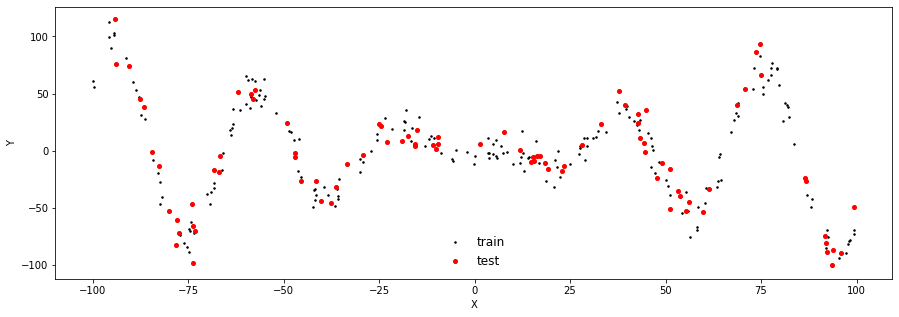

In [3]:
sample_size = 300
variance = 10 # La variance du bruit Gaussien
scale = 100  # L'étendue
period = 6 # La simulation est basée sur la fonction cosinus (voir la fonction data_simulation)

x_train, y_train = data_simulation_(int(.7*sample_size), scale, period, 
                                    variance)
x_test, y_test = data_simulation_(int(.3*sample_size), scale, period, variance)

# Cette fonction est dans le fichier utilities.py
plt = scatter_plot(x_train, x_test, y_train, y_test)   

### 1.1.2 Obtenir une première intuition visuelle de la capacité du modèle

Comme vu dans le cours (par exemple diapo 38), plus haute est la capacité du modèle, meilleur le modèle sera sur l'ensemble d'entraînement (attention, encore une fois, ça ne dit rien sur sa capacité à généraliser). Pour l'instant, nous entraînerons un modèle de [régression polynomiale](https://fr.wikipedia.org/wiki/R%C3%A9gression_polynomiale). 
L'avantage de ce modèle est que nous pouvons facilement changer sa capacité en augmentant le degré du polynôme $m$:

$$\hat{y} = \sum_{i=1}^m w_i x^i $$
 
mais ce n'est pas très important de comprendre les détails du modèle.

**Questions**: 
1. Observez l'effet du degré du polynôme sur sa capacité à prédire les données. 
2. À votre avis, vaut-il mieux utiliser un polynôme de degré 20 ou 50?
3. Lesquels de ces polynômes devraient avoir la meilleure erreur de généralisation?


Polynomial degree:  0  | MSE train: 1897.8148  | MSE test: 2090.1397
Polynomial degree:  1  | MSE train: 1834.8547  | MSE test: 2035.8692
Polynomial degree:  3  | MSE train: 1640.1539  | MSE test: 1785.4183
Polynomial degree:  5  | MSE train: 1301.8234  | MSE test: 1389.8382
Polynomial degree:  10  | MSE train: 950.7313  | MSE test: 1069.6461
Polynomial degree:  20  | MSE train: 69.1318  | MSE test: 112.8808
Polynomial degree:  40  | MSE train: 62.125  | MSE test: 124.7164


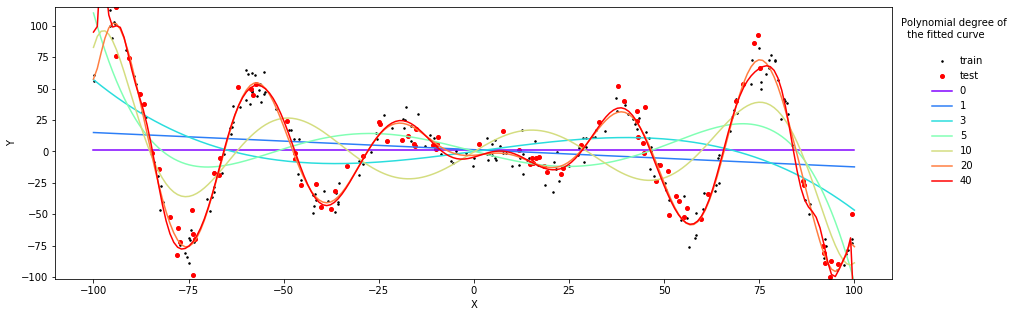

In [4]:
# Entraîner de polynômes de différents degrés: plus le degré est élevé plus la capacité du modèle l'est.
degree = [0, 1, 3, 5, 10, 20, 40]   
plot_polynomial_curves(x_train, x_test, y_train, y_test, degree, scale)

### 1.1.3 Taille échantillonnale et capacité du modèle

Dans la section précédente, nous avons discuté de la capacité du modèle. 

Maintenant, nous étudions comment le modèle varie et performe en fonction de la taille des données d'entraînement (pour référence, voir diapo 40 et figure 5.4 du livre "Deep Learning"). 

Nous étudions le modèle de régression polynomiale de degré 3 comparé à celui de degré optimal (c.-à-d. celui qui minimise la MSE sur l'ensemble de test).

**Question**: Les courbes ci-dessous semblent-elles se comporter raisonnablement?


[0, 1, 3, 5, 10, 20, 40]


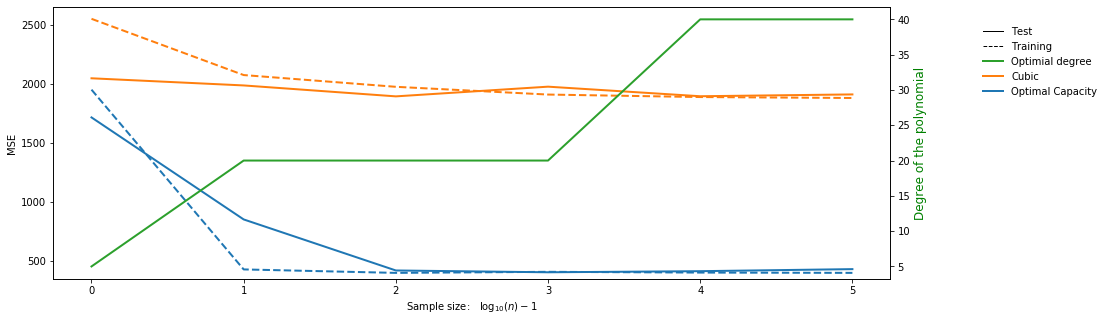

In [5]:
# Taille échantillonnale 
sample_size = [10, 10**2, 10**3, 10**4, 10**5, 10**6]   
variance = 20

print(degree)

H_train, H_test, optimal_train, optimal_test, optimal_degree \
    = train_poly_and_see(sample_size, scale, period, variance, degree)

plot_optimal_curve(optimal_train, optimal_test, H_train, H_test, optimal_degree)

# 1.2 Biais et variance des estimateurs

Nous explorons maintenant quelques propriétés du biais et de la variance de quelques estimateurs bien connus. 

##  Modèles linéaires pour la régression

Les modèles polynomiaux que nous venons d'utiliser font partie d'une classe de modèles s'appelant modèles linéaires. Ils sont appelés ainsi puisque la variable cible ($y$) est prédite par une combinaison linéaire des caractéristiques ($x$).  

En particulier, c'est une tâche de régression linéaire où le but est de prédire une (ou plus) variable(s) cible(s) continue(s) étant donné les valeurs d'un ensemble de variables indépendantes. 

De plus, nous posons que notre objectif est l'erreur au carré 
$$\sum_{i=0}^n (y_i - \hat{y}_i)^2$$

ou mean squared error (MSE) en anglais. 

Nous allons maintenant étudier quelques propriétés de ce modèle et de cette fonction d'erreur.

Note: Un modèle de régression linéaire appris avec une erreur au carrée est appelé régression des moindres carrés ordinaire (ordinary least square ou OLS en anglais). 

Pour commencer, simulons des données. 

### 1.2.1 Simulation de données 

Chaque observation $y$ est générée par le modèle suivant :

$$ y = \bf{x}^\top \bf{w} + \epsilon$$

où $y \in \mathbb{R}$ est la sortie, $\bf{x}$ le vecteur de variables indépendantes,  $\bf{w}$ le vecteur des paramètres et $\epsilon$ est le bruit gaussien $\epsilon \sim \mathcal{N}(0,11)$.

In [23]:
def data_simulation(sample_size, w_0, w_1):
    
    x = np.random.uniform(-1, 10, sample_size)
    x.sort()
    noise = np.random.normal(0, 11, sample_size)
    y = w_0 + w_1 * x + noise
    
    return x, y

Nous pouvons visualiser les données générées.

<module 'matplotlib.pyplot' from '/Users/lcharlin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

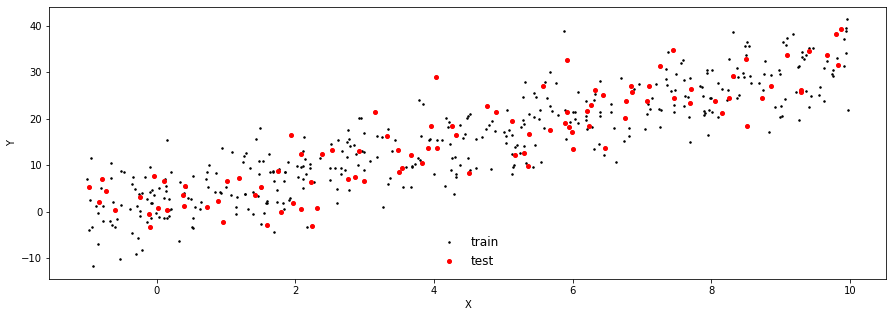

In [25]:
w_0, w_1 = 2, 3   # Pour des valeurs de w connues
sample_size = 500   # On génére un nombre fixe de données d'entraînement

X, y = data_simulation(sample_size, w_0, w_1)
X = [np.ones(len(y)), X]
X = np.asarray(X ).T

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)
scatter_plot(X_train[:, 1], X_test [:, 1], y_train, y_test) 

### 1.2.2 Estimateurs OLS

**Questions**: 
1. Étant donné l'expression des moindres carrés donnée à la diapo 31 du cours, complétez le fonction OLS ci-dessous pour obtenir les estimateurs moindres carrés. Pour rappel, ces estimateurs sont définis comme suit (il vous suffit donc d'implémenter cette formule dans la fonction OLS):

$$ \hat{\bf{w}}^{\text{OLS}} := (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}$$

où $\bf{X}$ est la matrice de variables indépendantes (en anglais [design matrix](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.) et $\bf{y}$ est le vecteur de sortie.

2. Calculez les estimateurs associés aux données simulées

*Note*: N'oubliez pas de calculer l'ordonnée à l'origine $\bf{w}_0$. Pour ce faire, vous pouvez ajouter une colonne avec seulement des 1 à la matrice de variables indépendantes. (Explications en anglais [ici](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.).

**Réponse**:

In [1]:
def OLS(X, y):
    """
    X: matrice de variables indépendantes
    y: vecteur des cibles
    
    return:  array of weights
    """
    
    A = np.linalg.inv(np.dot(X.T, X))
    B = np.dot(X.T, y)

    # À COMPLÉTER :    
    return (...)

w_ols = OLS(X_train, y_train)

NameError: name 'X_train' is not defined

**Question**: Calculez les prédictions sur les ensembles d'entraînement et de test. À partir de ces prédictions, calculez l'erreur MSE. Les résultats vous semblent-ils raisonnables?

**Answer**:

In [27]:
# Train set
y_hat_train = ... 

# Test set
y_hat_test = ... 

print('MSE en entraînement: ', MSE(y_hat_train, y_train))
print('MSE en test:  ', MSE(y_hat_test, y_test))

MSE en entraînement:  26.255209347316768
MSE en test:   25.524953820995712


#### 1.2.2.1 Biais de l'estimateur des moindres carrés

**Question**: Calculez le biais (empirique) des estimateurs.

**Réponse**:

In [28]:
bias = ...

print("Biais de w_0: ", bias[0])   # Bias of w_0
print("Biais de w_1: ", bias[1])   # Bias of w_1

Biais de w_0:  0.009246856398277714
Biais de w_1:  0.017635938784052563


**Question**: Ces valeurs sont-elle raisonnables?

**Question Bonus**: Comment réduire le biais empirique de ces estimateurs?

In [29]:
sample_size = 10**6

#### 1.2.2.2 Variance des estimateurs OLS (à sauter si manque de temps)

Les estimateurs OLS calculés à la section précédente sont en fait des variables aléatoires. Ces estimateurs ont donc une variance. 

Cette variance peut être estimée de plusieurs façons. Nous en introduisons ici deux. La première est une approche empirique utilisant une méthode de Monte Carlo (c.-à-d. par échantillonnage). La seconde, est une approach analytique. 


#### Méthode Monte Carlo

Malgré leur nom, les méthodes de Monte Carlo peuvent être relativement simples. Nous allons évaluer la variance de nos estimateurs en 4 étapes faciles. 

In [30]:
# L'idée est que nous allons réestimer les estimateurs à partir de plusieurs 
# jeux de données. 
# Chaque jeu de données est tiré de la même distribution (ou du même processus de génération). 
# Nous allons ensuite pouvoir trouver la variance empirique des estimateurs.

mc_estimates = 100 # Nombres d'estimations de Monte Carlo que vous allez utiliser
M = np.zeros((mc_estimates, 2)) # Matrice où conserver les estimateurs

# Step 1: Boucle for pour chaque estimation.
for k in np.arange(mc_estimates):
    
    # Step 2: Simulation des données
    x, y = data_simulation( int(.8 * sample_size), w_0, w_1)
    
    X = [np.ones(len(y)), x]   
    X = np.asarray(X).T
    
    # Step 3: Estimations OLS
    w_ols = OLS(X, y)
    M[k, :] = w_ols   # On conserve les estimateurs
    
# Step 4: On calcule la variance (indice: fonction np.var)
var = np.var(M, axis=0)
print("Estimation MC de la variance de l'estimateur de w_0: ", var[0]) # Variance de w_0
print("Estimation MC de la variance de l'estimateur de w_1: ",var[1])  # Variance de w_1

Estimation MC de la variance de l'estimateur de w_0:  8.526898306870222e-05
Estimation MC de la variance de l'estimateur de w_1:  3.127568686703808e-06


#### Approche Analytique 

Nous pouvons aussi obtenir l'expression de la variance directement. Ceci est pratique dans certains cas où nous ne pouvons utilisez la méthode de Monte Carlo. 

\begin{align}
    \text{Var}(\hat{\bf{w}}^{\text{OLS}}) 
    &= \text{Var}\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}\right) && \text{Definition of the OLS estimators}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y})\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \right)^\top && \text{Property of the variance on matrices} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y}) \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the transpose}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{X} \bf{w} + \bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Modelization of the data}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the variance (only $\epsilon$ is a random variable)} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{I} \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Since $\epsilon$ is iid}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top  \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= \left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= (\bf{X}^\top \bf{X})^{-1} && \text{Since $\bf{X}^\top \bf{X}$ is symmetric and}\\
    & && \text{by property of the matrix inv.}
\end{align}

**Question**: Calculez la variance des estimateurs OLS en utilisant l'expression ci-dessus.

**Réponse**:

In [31]:
# Calcul
var = ... 

print("Variance analytique de l'estimé de w_0: ", var[0, 0])   
print("Variance analytique de l'estimé de w_1: ",var[1, 1])   

Variance analytique de l'estimé de w_0:  0.006753013933156844
Variance analytique de l'estimé de w_1:  0.00023519713794636034


**Question**: Les résultats analytiques précédents sont-ils raisonnables? 

### 1.2.3 Estimateurs des moindres carrés (OLS) avec régularisation L2

Comme montré à la diapo 45, on peut ajouter une régularisation L$_2$ sur les paramètres d'un modèle linéaire (voir la section 1.1). 

Le problème est connu sous le nom de (régression d'arête, ridge ou de Tikhonov)
[https://en.wikipedia.org/wiki/Tikhonov_regularization] :

$$ \hat{w}^{\text{ridge}} := (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{y}$$

où $\lambda$ est l'hyperparamètre (voir diapos 45 et 46) qui contrôle la capacité du modèle.

**Question**: Complétez la fonction ridge ci-dessous pour obtenir les estimateurs d'arêtes.

**Réponse**:

In [32]:
def ridge(X, y, lambda_hp):
    
    A = ...
    B = ... 
    
    return np.dot(A, B)

**Question**: Obtenez les estimateurs d'arête pour différentes valeurs de $\lambda$. En premier, essayer d'imaginer comment les estimateurs vont changer pour des valeurs de $\lambda$ suivants: 

1. For $\lambda = 0$. 
2. For $\lambda = 10^{10}$.
3. Pour des valeurs intermédiaires de $\lambda$ (entre $0$ et $10^{10}$)?  

In [33]:
lambda_hp = 10**3
w_ridge = ridge(X_train, y_train, lambda_hp)

**Question**: Obtenez des prédictions sur l'ensemble d'entraînement et de test. Ce modèle est-il meilleur que le modèle sans régularisation (OLS)?

**Réponse**:

In [34]:
# Train set
y_hat_train = ... 

# Test set
y_hat_test = ... 

print('MSE en entraînement: ', MSE(y_hat_train, y_train))
print('MSE en test:  ', MSE(y_hat_test, y_test))

MSE en entraînement:  28.85814500880032
MSE en test:   28.754323122145074


#### 1.2.3.1 Biais des estimateurs d'arête

**Question**: Calculez le biais des estimateurs d'arête.

**Réponse**:

In [35]:
bias = ...

print("Biais de w_0: ", bias[0])   # Bias de w_0
print("Biais de w_1: ", bias[1])   # Bias de w_1

Biais de w_0:  -1.3587023350491831
Biais de w_1:  -0.03769655685412143


**Question**: Comparez le biais des estimateurs d'arête avec les estimateurs OLS. Les différences sont-elles raisonnables?

**Réponse**: Les estimateurs d'arête sont biaisés. Leur biais empirique devrait être plus grand que le biais des estimateuers OLS (par contre, leur variance pourrait être plus petite). 

On peut voir plus formellement que les estimateurs d'arête sont biaisés.  

\begin{align}
    \mathbb{E}[\hat{\bf{w}}^{\text{ridge}}] 
    &= \mathbb{E}[(\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{y}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \mathbb{E}[\bf{y}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \mathbb{E}[\bf{X} \bf{w} + \bf{\epsilon}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \{ \mathbb{E}[\bf{X} \bf{w}] + \mathbb{E}[\bf{\epsilon}] \} \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \{ \bf{X} \bf{w} + \bf{O} \} \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{X} \bf{w}  \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} (\bf{X}^\top \bf{X} + \lambda \bf{I} - \lambda \bf{I} ) \bf{w}  \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} (\bf{X}^\top \bf{X} + \lambda \bf{I}) \bf{w} -  (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1}\lambda \bf{I} \bf{w}  \\
    &=  \bf{w} -  \lambda (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{w}.
\end{align}

Donc, le biais des estimateur d'arête est:
$$ \text{Bias}(\hat{\bf{w}}^{\text{ridge}})   = -  \lambda (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{w}  $$


**Remarque**: Comment choisir la valeur de l'hyperparamètre $\lambda$? Nous en discutons à la section suivante.

## 1.3 Validation - Pour trouver de bons hyperparamètres

La validation est utile pour faire une sélection de modèles ainsi que pour trouver des bons hyperparamètres.

La première étape de validation consiste à diviser l'ensemble d'entraînement en deux ensembles, un d'entraînement et un de validation (voir diapo 49). 

En python, on peut simplement utiliser la fonction train_test_split de la libraire  [Scikit-learn library](https://scikit-learn.org/). (Notez que nous introduirons les différentes fonctionnalités de ces libraires à la semaine 4 du cours.)

In [36]:
X_sub_train, X_validation, y_sub_train, y_validation = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=0)

Nous pouvons maintenant étudier la performance (MSE) de l'estimateur avec régularisation L2 en fonction de la valeur des hyperparamètres. 

Dans ce cas, le seul hyperparamètre est l'importance de la régularisation $\lambda$.


In [37]:
losses_stack_sub_train, losses_stack_train = [], [] 
losses_stack_validation, losses_stack_test = [], []

for lambda_hp in np.arange(0, 100, 1):

    # Apprendre les paramètres (w) avec une valeur de lambda 
    w_ridge_cv = ridge(X_sub_train, y_sub_train, lambda_hp)
    
    # Obtenir des prédictions sur l'ensemble d'entraînement et de validation
    y_hat_sub_train = np.dot(X_sub_train, w_ridge_cv)
    y_hat_validation = np.dot(X_validation, w_ridge_cv)
    
    # Calculez et conserver les valeurs des erreurs MSE
    losses_stack_sub_train.append(MSE(y_sub_train, y_hat_sub_train))
    losses_stack_validation.append(MSE(y_validation, y_hat_validation))
    
    # On obtient la même chose pour nos ensembles d'entraînement et de test initiaux.
    w_ridge = ridge(X_train, y_train, lambda_hp)
    y_hat_train = np.dot(X_train, w_ridge)
    y_hat_test = np.dot(X_test, w_ridge)

    losses_stack_train.append(MSE(y_train, y_hat_train))
    losses_stack_test.append(MSE(y_test, y_hat_test))

En fonction des erreurs MSE sur l'ensemble de validation, nous pouvons maintenant sélectionner la meilleure valeur de l'hyperparamètre $\lambda$. 

Attention: il ne faut jamais sélectionner les valeurs des hyperparamètres à partir de l'ensemble de test. 

La régularisation optimale est de 0


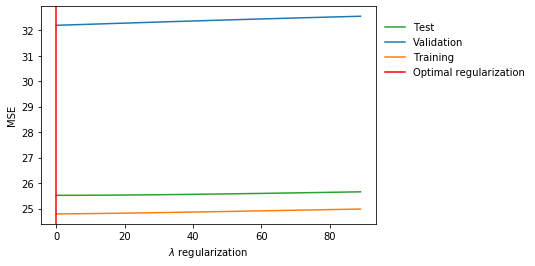

In [42]:
cmap = plt.get_cmap("tab10")

plt.plot(losses_stack_test, label='Test', color=cmap(2))
plt.plot(losses_stack_validation, label='Validation', color=cmap(0))
plt.plot(losses_stack_sub_train, label='Training', color=cmap(1))

plt.axvline(x=np.argmin(losses_stack_validation), color='red', label='Régularisation optimale')

plt.xlabel('$\lambda$ regularization')
plt.ylabel('MSE')
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .8))
leg.get_frame().set_alpha(0)
print('La régularisation optimale est de', np.argmin(losses_stack_validation))


Nous pouvons aussi comparer les erreurs des différents estimateurs sur l'ensemble de test:

In [39]:
print('TRAIN: estimateurs OLS:   ', losses_stack_train[0])
print('TRAIN: estimateurs Ridge: ', losses_stack_train[np.argmin(losses_stack_validation)])

print('\nTEST: estimateurs OLS:   ', losses_stack_test[0])
print('TEST: estimateurs Ridge: ', losses_stack_test[np.argmin(losses_stack_validation)])

TRAIN: estimateurs OLS:    26.259016856161516
TRAIN: estimateurs Ridge:  26.259016856161516

TEST: estimateurs OLS:    25.520015082615195
TEST: estimateurs Ridge:  25.520015082615195


## 1.4 Remarques finales

1. Un modèle de plus haute capacité pourra mieux modéliser l'ensemble d'entraînement, mais attention à l'erreur de généralisation. 
2. Un estimateur non biaisé (OLS par rapport à Ridge) n'offre pas nécessairement une meilleure erreur de généralisation.
3. Quand l'erreur est la MSE, on peut décomposer l'erreur de généralisation par rapport au biais et à la variance des estimateurs.
4. La validation est très utile, on vous conseille de bien comprendre la Section 1.3!